<h2 > <span style='background-color: white; color: #454545;  padding: 20px; border-bottom-right-radius: 1em; border-top-right-radius: 1em; border-left: 10px solid gray; font-style: italic; font-weight: bold'>Importing Packages</span></h2>

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

<h2 > <span style='background-color: white; color: #454545;  padding: 20px; border-bottom-right-radius: 1em; border-top-right-radius: 1em; border-left: 10px solid gray; font-style: italic; font-weight: bold'>Reading CSV files</span></h2>

In [69]:

train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
original_data = pd.read_csv('./archive/Churn_Modelling.csv')

<h2 > <span style='background-color: white; color: #454545;  padding: 20px; border-bottom-right-radius: 1em; border-top-right-radius: 1em; border-left: 10px solid gray; font-style: italic; font-weight: bold'> Different-type Features</span></h2>

In [70]:
numerical_variables = ['CreditScore','Age', 'Balance','EstimatedSalary' ]
target_variable = 'Exited'
categorical_variables = ['Geography', 'Gender', 'Tenure','NumOfProducts', 'HasCrCard','IsActiveMember']

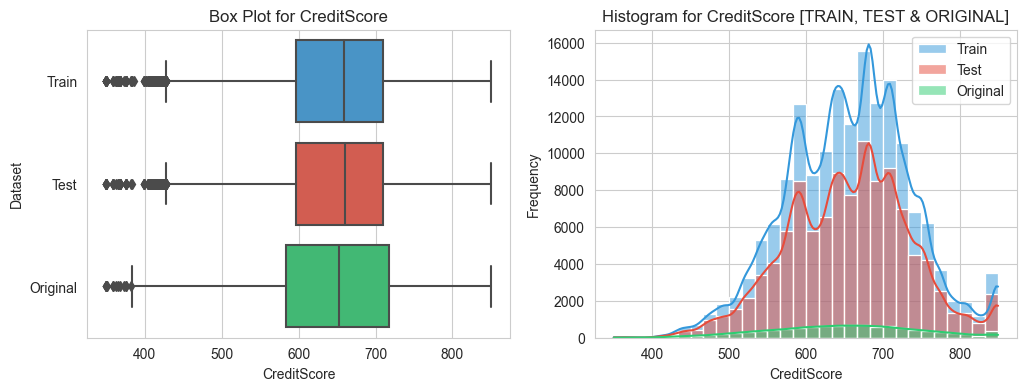

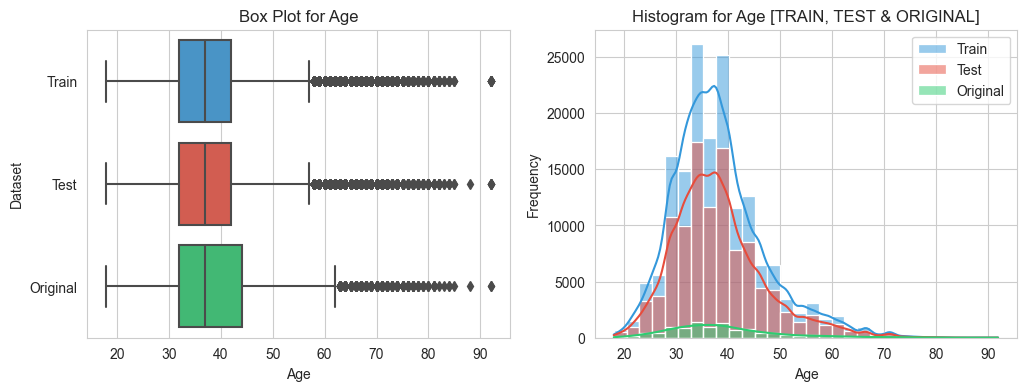

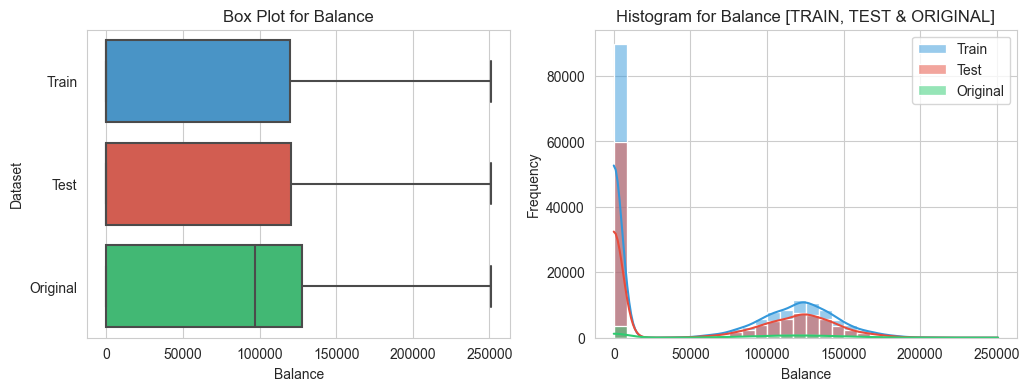

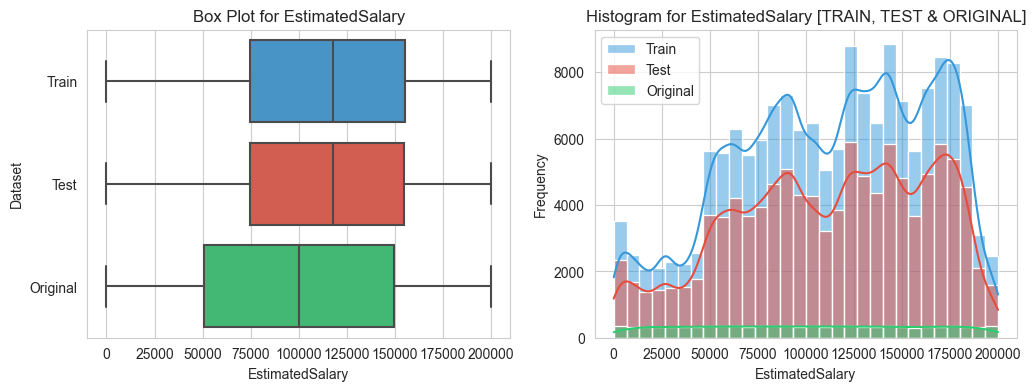

In [71]:

custom_palette = ['#3498db', '#e74c3c','#2ecc71']
train_data['Dataset'] = "Train"
test_data["Dataset"] = "Test"
original_data['Dataset'] = "Original"

variables = [col for col in train_data.columns if col in numerical_variables]
def create_variable_plots(variable):
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train_data, test_data, original_data.dropna()]), x=variable, y='Dataset', palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test_data, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    sns.histplot(data=original_data.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST & ORIGINAL]")
    plt.legend()
    plt.show()

for variable in variables:
    create_variable_plots(variable)
    
train_data.drop('Dataset', axis=1, inplace=True)
test_data.drop('Dataset', axis=1, inplace=True)
original_data.drop('Dataset', axis=1, inplace=True)

In [72]:
variables = [col for col in train_data.columns if col in numerical_variables]

cat_variables_train = ["NumOfProducts", "HasCrCard", "IsActiveMember", "Tenure", "Exited"]
cat_variables_test = ["NumOfProducts", "HasCrCard", "IsActiveMember", "Tenure"]


train_variables = variables + cat_variables_train
test_variables = variables + cat_variables_test


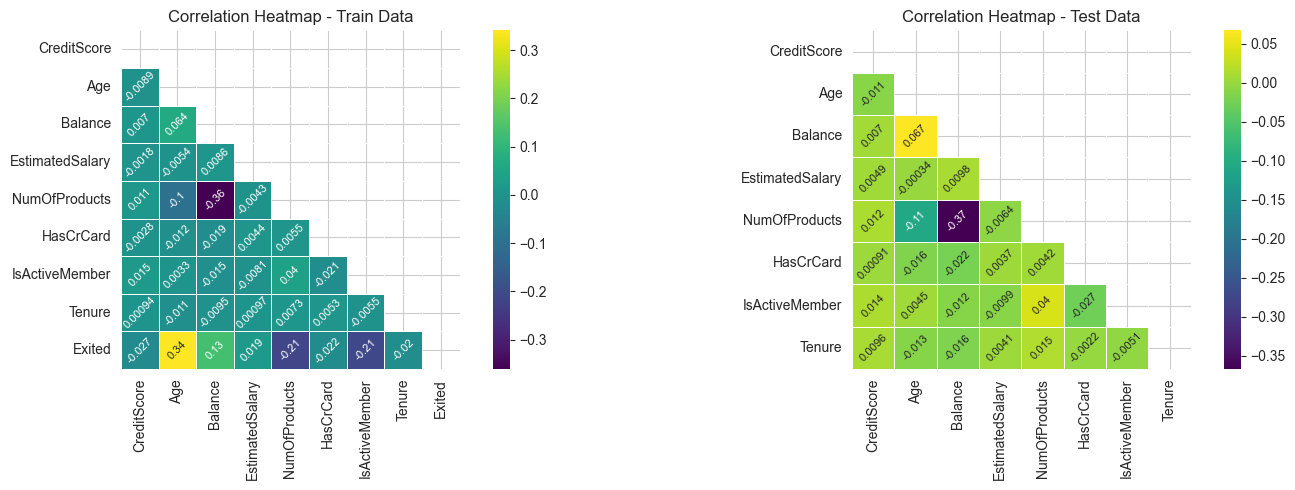

In [73]:

corr_train = train_data[train_variables].corr()
corr_test = test_data[test_variables].corr()

mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))
annot_kws = {"size": 8, "rotation": 45}
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap='viridis', annot=True
                       , square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title("Correlation Heatmap - Train Data")
plt.subplot(1, 2, 2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap='viridis', annot=True,
                     square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Test Data')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [74]:


def tf_idf(df, column, n, p):
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=n)
    
    # Transform data
    vectors = vectorizer.fit_transform(df[column])
    
    # Apply TruncatedSVD for dimensionality reduction
    svd = TruncatedSVD(p)
    x_pca = svd.fit_transform(vectors)
    
    # Convert to DataFrame
    tfidf_df = pd.DataFrame(x_pca)

    # Naming columns in the new DataFrame
    cols = [(column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols
    
    # Reset the index of the DataFrame before concatenation
    df = df.reset_index(drop=True)

    # Concatenate transformed features with original data
    df = pd.concat([df, tfidf_df], axis="columns")
    
    return df

def perform_feature_engineering(df):
    # Age Group
    age_bins = [0, 18, 30, 40, 50, 60, 100]
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=False, right=False)

    # Balance Category
    balance_bins = [-np.inf, 0, 10000, 50000, 100000, np.inf]
    df['BalanceCategory'] = pd.cut(df['Balance'], bins=balance_bins, labels=False, right=False)

    # Credit Score Category
    credit_bins = [0, 500, 600, 700, 800, 850]
    df['CreditScoreCategory'] = pd.cut(df['CreditScore'], bins=credit_bins, labels=False, right=False)

    # Tenure Group
    tenure_bins = [0, 2, 5, 10, np.inf]
    df['TenureGroup'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=False, right=False)

    # Salary to Balance Ratio
    df['SalaryToBalanceRatio'] = df['EstimatedSalary'] / (df['Balance'] + 1)  # Adding 1 to avoid division by zero

    # Credit Card and Active Member Interaction
    df['CreditCard_ActiveMember'] = df['HasCrCard'] * df['IsActiveMember']

    # Apply TF-IDF to 'Surname' column
    df = tf_idf(df, 'Surname', n=1000, p=5)

    # ABP Interaction
    df['ABPInteraction'] = df['Age'] * df['Balance'] / df['NumOfProducts']

    df['Geo_Gender'] = df['Geography'] + '_' + df['Gender']
        
    df['Products_Per_Tenure'] = np.where(df['Tenure'] != 0, df['NumOfProducts'] / df['Tenure'], df['NumOfProducts'])
    
    df['Customer_Status'] = df['Tenure'].apply(lambda x: 'New' if x < 2 else 'Long-term')
    
    return df

# Apply the function to the training data
train_data = perform_feature_engineering(train_data)

# Apply the function to the test data
test_data = perform_feature_engineering(test_data)

In [75]:
train_data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,CreditCard_ActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,ABPInteraction,Geo_Gender,Products_Per_Tenure,Customer_Status
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0.0,5.060457e-08,1.578230e-08,1.140901e-06,7.556334e-08,-1.606255e-06,0.00,France_Male,0.666667,Long-term
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,1.0,-4.688550e-08,3.383473e-07,-1.068790e-06,-5.054482e-07,-3.278808e-06,0.00,France_Male,2.000000,New
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0.0,-2.585202e-04,5.235600e-03,-3.659509e-03,2.674361e-02,6.195889e-02,0.00,France_Male,0.200000,Long-term
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,1.0,1.371254e-04,-4.716793e-04,-1.762894e-03,5.230723e-03,8.509503e-03,5062006.36,France_Male,0.500000,Long-term
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,1.0,-1.019738e-08,-4.844014e-07,-1.182310e-06,-4.620399e-07,1.542767e-06,0.00,Spain_Male,0.400000,Long-term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,...,1.0,1.531950e-11,-5.737501e-10,1.210541e-10,-4.140312e-10,-3.490956e-10,0.00,Spain_Female,0.500000,Long-term
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,...,0.0,2.668714e-07,-3.725143e-06,1.664254e-07,9.453618e-07,-2.938451e-06,0.00,France_Male,0.333333,Long-term
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,...,1.0,1.125390e-04,9.998698e-01,-2.935566e-03,2.289018e-03,3.107128e-03,0.00,France_Male,0.200000,Long-term
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,...,0.0,-8.119947e-05,-1.233071e-03,2.937218e-03,-1.255996e-03,-3.760950e-03,4845990.00,Spain_Female,0.142857,Long-term


In [76]:
columns_to_drop = ['CustomerId','Surname']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)
original_data.drop(['CustomerId','RowNumber','Surname'], axis=1, inplace=True)

In [77]:
columns_to_check = numerical_variables

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for column in columns_to_check:
    train_data = remove_outliers_iqr(train_data, column)

In [78]:
y = train_data['Exited']

In [79]:

skewed_features = train_data[numerical_variables].skew()[train_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
train_data[skewed_features] = np.log1p(train_data[skewed_features])

Features to be transformed (skewness > 0.75):


array([], dtype=object)

In [80]:
# [FOR TEST]
# Identify features with skewness greater than 0.75
# Get the index of the data to be transformed
skewed_features = test_data[numerical_variables].skew()[test_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
test_data[skewed_features] = np.log1p(test_data[skewed_features])

Features to be transformed (skewness > 0.75):


array(['Age'], dtype=object)

In [81]:
# Selecting specific columns for encoding
columns_to_encode = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember','Geo_Gender','Customer_Status']
train_data_to_encode = train_data[columns_to_encode]
test_data_to_encode = test_data[columns_to_encode]

# Dropping selected columns for scaling
train_data_to_scale = train_data.drop(columns_to_encode, axis=1)
test_data_to_scale = test_data.drop(columns_to_encode, axis=1)

In [82]:
# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in train_data
train_data_encoded = pd.get_dummies(train_data_to_encode, columns=['Geography', 'Gender','NumOfProducts', 'HasCrCard','IsActiveMember','Geo_Gender','Customer_Status'], drop_first=True)

# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in test_data
test_data_encoded = pd.get_dummies(test_data_to_encode, columns=['Geography', 'Gender','NumOfProducts', 'HasCrCard','IsActiveMember','Geo_Gender','Customer_Status'], drop_first=True)

In [83]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
standard_scaler = StandardScaler()

# Fit the scaler on the training data
standard_scaler.fit(train_data_to_scale.drop(['Exited'], axis=1))

# Scale the training data
scaled_data_train = standard_scaler.transform(train_data_to_scale.drop(['Exited'], axis=1))
scaled_train_df = pd.DataFrame(scaled_data_train, columns=train_data_to_scale.drop(['Exited'], axis=1).columns)

# Scale the test data using the parameters from the training data
scaled_data_test = standard_scaler.transform(test_data_to_scale)
scaled_test_df = pd.DataFrame(scaled_data_test, columns=test_data_to_scale.columns)

In [84]:
# Concatenate train datasets
train_data_combined = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)

# Concatenate test datasets
test_data_combined = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)

In [85]:
# Add the 'Exited' column back to the scaled training data
train_data_combined['Exited'] = train_data['Exited'].values

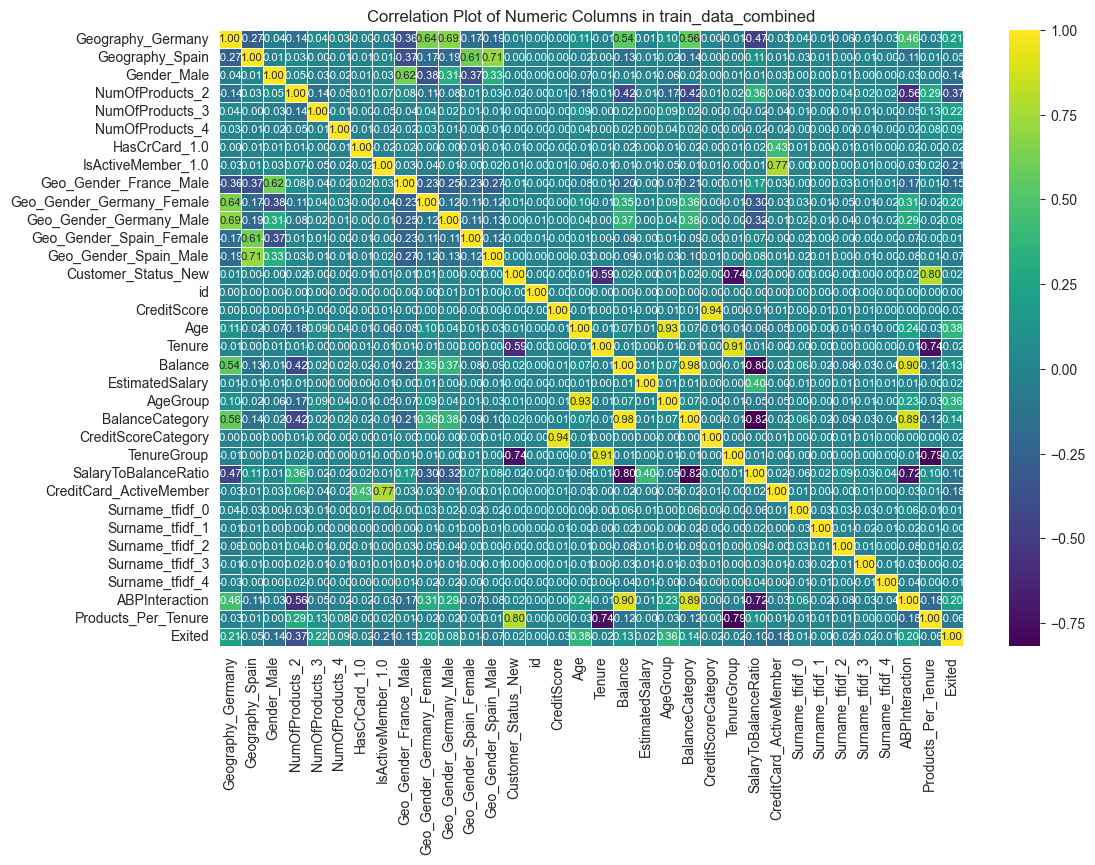

In [86]:
# Select numeric columns
numeric_cols = train_data_combined.select_dtypes(include=['number', 'bool'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Create a heatmap using Seaborn with smaller font size for annotations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Plot of Numeric Columns in train_data_combined')
plt.show()

In [87]:
train_data_combined.drop(['CreditScore','Age','Tenure','Balance','EstimatedSalary','CreditCard_ActiveMember'],axis=1,inplace=True)

In [88]:
test_data_combined.drop(['CreditScore','Age','Tenure','Balance','EstimatedSalary','CreditCard_ActiveMember'],axis=1,inplace=True)

In [98]:

# Set a seed for reproducibility
seed = 42

# Initialize all the classification models in the requested format
log_reg = LogisticRegression(random_state=seed, max_iter=1000000)
svc = SVC(random_state=seed, probability=True)
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()
bnb = BernoulliNB()
knn = KNeighborsClassifier()
gauss = GaussianProcessClassifier(random_state=seed)
cb = CatBoostClassifier(random_state=seed, verbose=0)
rf = RandomForestClassifier(random_state=seed)
et = ExtraTreesClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
lgb = LGBMClassifier(random_state=seed)
dart = LGBMClassifier(random_state=seed, boosting_type='dart')
gb = GradientBoostingClassifier(random_state=seed)
hgb = HistGradientBoostingClassifier(random_state=seed)

[LightGBM] [Info] Number of positive: 22790, number of negative: 88090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 110880, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205538 -> initscore=-1.352037
[LightGBM] [Info] Start training from score -1.352037


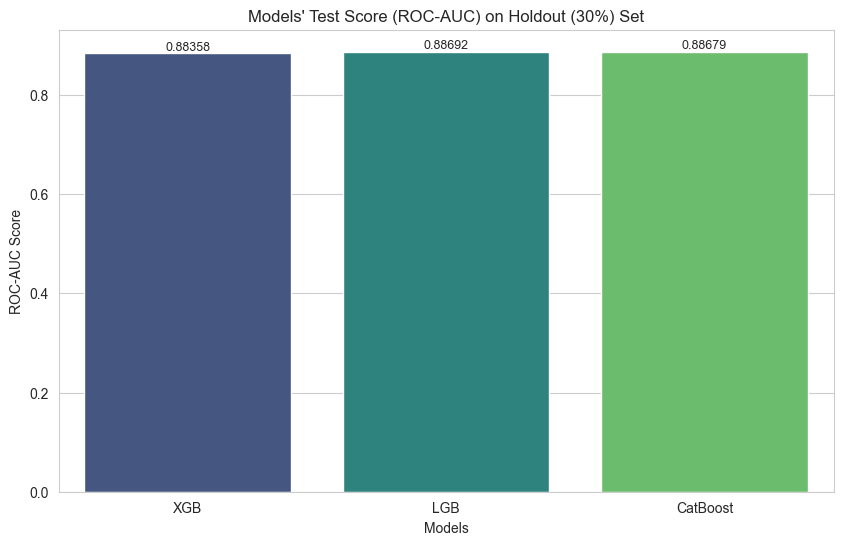

In [99]:
X = train_data_combined.drop('Exited',axis=1)
y = train_data_combined['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize classifiers
xgb = XGBClassifier(random_state=seed)
lgb = LGBMClassifier(random_state=seed)
cb = CatBoostClassifier(random_state=seed, verbose=0)

models = [xgb, lgb, cb]

def train_test_split_roc_auc(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    
    return roc_auc_train, roc_auc_test

roc_auc_scores_train = []
roc_auc_scores_test = []

for model in models:
    roc_auc_train, roc_auc_test = train_test_split_roc_auc(model, X_train, y_train, X_test, y_test)
    roc_auc_scores_train.append(roc_auc_train)
    roc_auc_scores_test.append(roc_auc_test)

# Create a DataFrame with the scores and sort it
roc_auc_scores_df = pd.DataFrame(data={'ROC_AUC_Train': roc_auc_scores_train, 'ROC_AUC_Test': roc_auc_scores_test}, index=['XGB', 'LGB', 'CatBoost'])

# Plot ROC-AUC scores
plt.figure(figsize=(10, 6))
barplot_roc_auc = sns.barplot(x=roc_auc_scores_df.index, y='ROC_AUC_Test', data=roc_auc_scores_df, palette='viridis')

# Add values on the bars
for index, value in enumerate(roc_auc_scores_df['ROC_AUC_Test']):
    barplot_roc_auc.text(index, value + 0.001, str(round(value, 5)), ha='center', va='bottom', fontsize=9)

plt.title("Models' Test Score (ROC-AUC) on Holdout (30%) Set")
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')
plt.show()

In [101]:
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# LGBM Model
lgb_params = {
    'max_depth': 8,
    'min_child_samples': 2,
    'learning_rate': 0.05530081215180204,
    'n_estimators': 669,
    'subsample': 0.30254466503794797,
    'colsample_bytree': 0.41087854836196963,
    'reg_alpha': 0.6241271382121083,
    'reg_lambda': 0.7111824512446496
}
lgb_model = lgb.LGBMClassifier(**lgb_params)

# XGBoost Model
xgb_params = {
    'max_depth': 6,
    'min_child_weight': 7,
    'learning_rate': 0.022213294578283638,
    'n_estimators': 797,
    'subsample': 0.9646514255068099,
    'colsample_bytree': 0.4208597039793016,
    'random_state': 42
}
xgb_model = XGBClassifier(**xgb_params)

# CatBoost Model
cat_params = {
    'iterations': 988,
    'depth': 9,
    'min_data_in_leaf': 16,
    'learning_rate': 0.02375062070726108,
    'verbose': 0
}
cat_model = CatBoostClassifier(**cat_params)

In [102]:

# Initializing Stratified K-Fold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initializing an MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=1000,
    random_state=42,
    activation='relu',
    learning_rate_init=0.001,
    solver='adam',
    validation_fraction=0.1,
    momentum=0.9,
    nesterovs_momentum=True,
    batch_size=32,
    beta_1=0.9,
    beta_2=0.999
)

# Creating a StackingClassifier
stacking_model = StackingClassifier(
    estimators=[
        ('LGBM', lgb_model),
        ('XGB', xgb_model),
        ('CAT', cat_model)
    ],
    final_estimator=mlp,
    cv=skf
)

In [103]:
X = train_data_combined.drop('Exited', axis=1)
y = train_data_combined['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

# Predict probabilities on the test set
stacking_test_predictions_proba = stacking_model.predict_proba(test_data_combined)[:, 1]

# Assuming 'test_data_combined' is the DataFrame for the test set
stacking_submission_df = pd.DataFrame({
    'id': test_data_to_scale['id'],
    'Exited': stacking_test_predictions_proba  # Fill in the predicted probabilities
})

# Save the submission DataFrame to a CSV file
stacking_submission_df.to_csv('submission.csv', index=False)

stacking_submission_df.head(10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22790, number of negative: 88090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 110880, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205538 -> initscore=-1.352037
[LightGBM] [Info] Start training from score -1.352037
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you 

,id,Exited
0,165034,0.012095
1,165035,0.609574
2,165036,0.031411
3,165037,0.171267
4,165038,0.326007
5,165039,0.038040
6,165040,0.026665
7,165041,0.030433
8,165042,0.436565
9,165043,0.008408
